<a href="https://colab.research.google.com/github/CD-AC/DataEngineer-SMS-Twilio/blob/main/SMS_Twilio_Weather_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

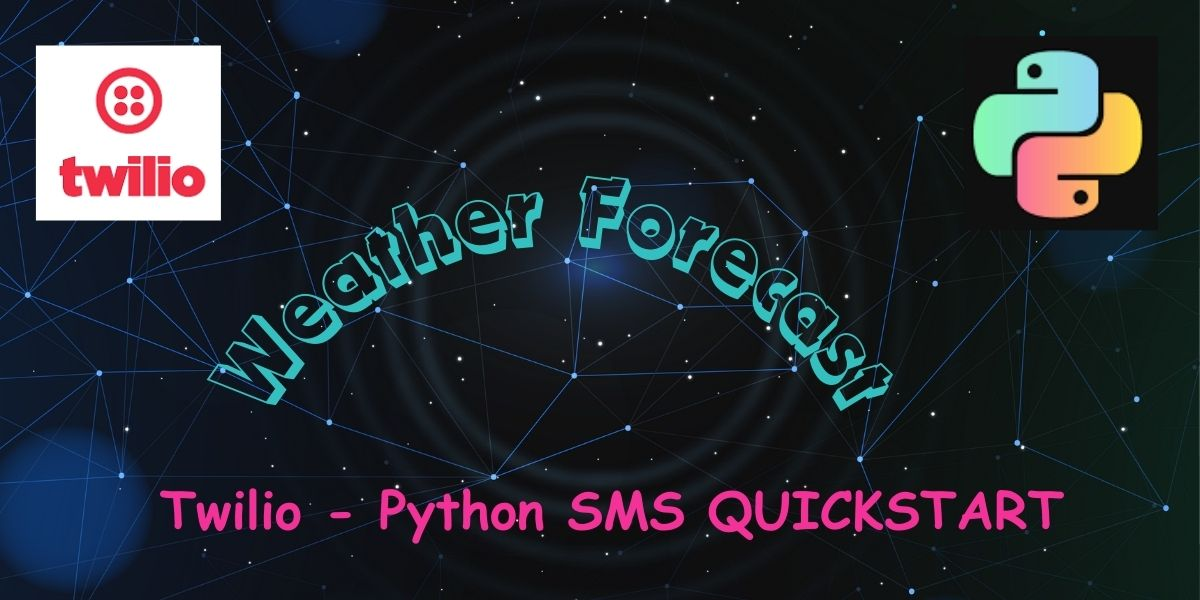

# Import dependencies

In [ ]:
!pip3 install twilio

In [ ]:
import os
from twilio.rest import Client
from twilio_config import *
import time
from requests import Request, Session
from requests.exceptions import ConnectionError, Timeout, TooManyRedirects
import json
import pandas as pd
import requests
from bs4  import BeautifulSoup
from tqdm import tqdm
from datetime import datetime

# Create URL

In [ ]:
query = 'Bogotá'
api_key = API_KEY_WAPI

url_clima = 'http://api.weatherapi.com/v1/forecast.json?key='+api_key+'&q='+query+'&days=1&aqi=no&alerts=no'
url_clima

'http://api.weatherapi.com/v1/forecast.json?key=b6868fe6faff4ba5ac513211242002&q=Bogotá&days=1&aqi=no&alerts=no'

# Create Dataframe

In [ ]:
response = requests.get(url_clima).json()

In [ ]:
response

In [ ]:
response.keys()

dict_keys(['location', 'current', 'forecast'])

In [ ]:
response['forecast']['forecastday'][0].keys()

dict_keys(['date', 'date_epoch', 'day', 'astro', 'hour'])

In [ ]:
len(response['forecast']['forecastday'][0]['hour'])

24

In [ ]:
response['forecast']['forecastday'][0]['hour'][0]

In [ ]:
response['forecast']['forecastday'][0]['hour'][0]['time'].split()[0] # Date

'2024-02-21'

In [ ]:
response['forecast']['forecastday'][0]['hour'][1]['time'].split()[1].split(':')[0] # Hour

'01'

In [ ]:
response['forecast']['forecastday'][0]['hour'][0]['will_it_rain']

0

In [ ]:
response['forecast']['forecastday'][0]['hour'][2]['chance_of_rain']

0

# Join Dataframe

In [ ]:
def get_forecast(response,i):

    fecha = response['forecast']['forecastday'][0]['hour'][i]['time'].split()[0]
    hora = int(response['forecast']['forecastday'][0]['hour'][i]['time'].split()[1].split(':')[0])
    condicion = response['forecast']['forecastday'][0]['hour'][i]['condition']['text']
    tempe = float(response['forecast']['forecastday'][0]['hour'][i]['temp_c'])
    rain = response['forecast']['forecastday'][0]['hour'][i]['will_it_rain']
    prob_rain = response['forecast']['forecastday'][0]['hour'][i]['chance_of_rain']

    return fecha,hora,condicion,tempe,rain,prob_rain

In [ ]:
datos = []

for i in tqdm(range(len(response['forecast']['forecastday'][0]['hour'])),colour = 'green'):
    datos.append(get_forecast(response,i))


100%|██████████| 24/24 [00:00<00:00, 30587.45it/s]


In [ ]:
datos[0]

('2024-02-21', 0, 'Mist', 11.2, 0, 0)

In [ ]:
col = ['Fecha','Hora','Condicion','Temperatura','Lluvia','prob_lluvia']
df = pd.DataFrame(datos,columns=col)
df = df.sort_values(by = 'Hora',ascending = True)
df

In [ ]:
df[df['Lluvia']==1]

,Fecha,Hora,Condicion,Temperatura,Lluvia,prob_lluvia
15,2024-02-21,15,Patchy rain nearby,20.2,1,87
16,2024-02-21,16,Patchy rain nearby,19.1,1,100
17,2024-02-21,17,Patchy rain nearby,17.7,1,88
21,2024-02-21,21,Patchy rain nearby,11.6,1,78


In [ ]:
df_rain =  df[(df['Lluvia']==1) & (df['Hora']>6) & (df['Hora']< 22)]
df_rain = df_rain[['Hora','Condicion']]
df_rain.set_index('Hora', inplace = True)

# SMS Template

In [ ]:
'\nHola! \n\n\n El pronostico del tiempo hoy '+ df['Fecha'][0] +' en ' + query +' es : \n\n\n ' + str(df_rain)

'\nHola! \n\n\n El pronostico del tiempo hoy 2024-02-21 en Bogotá es : \n\n\n                Condicion\nHora                    \n15    Patchy rain nearby\n16    Patchy rain nearby\n17    Patchy rain nearby\n21    Patchy rain nearby'

# Text message (SMS) sent through Twilio

In [ ]:
time.sleep(2)
account_sid = TWILIO_ACCOUNT_SID
auth_token = TWILIO_AUTH_TOKEN

client = Client(account_sid, auth_token)

message = client.messages \
                .create(
                     body='\nHola! \n\n\n El pronostico de lluvia hoy '+ df['Fecha'][0] +' en ' + query +' es : \n\n\n ' + str(df_rain),
                     from_=PHONE_NUMBER,
                     to='+573194127902'
                 )

print('Mensaje Enviado ' + message.sid)

Mensaje Enviado SMce6077f8731e6f079df914c57e82750a


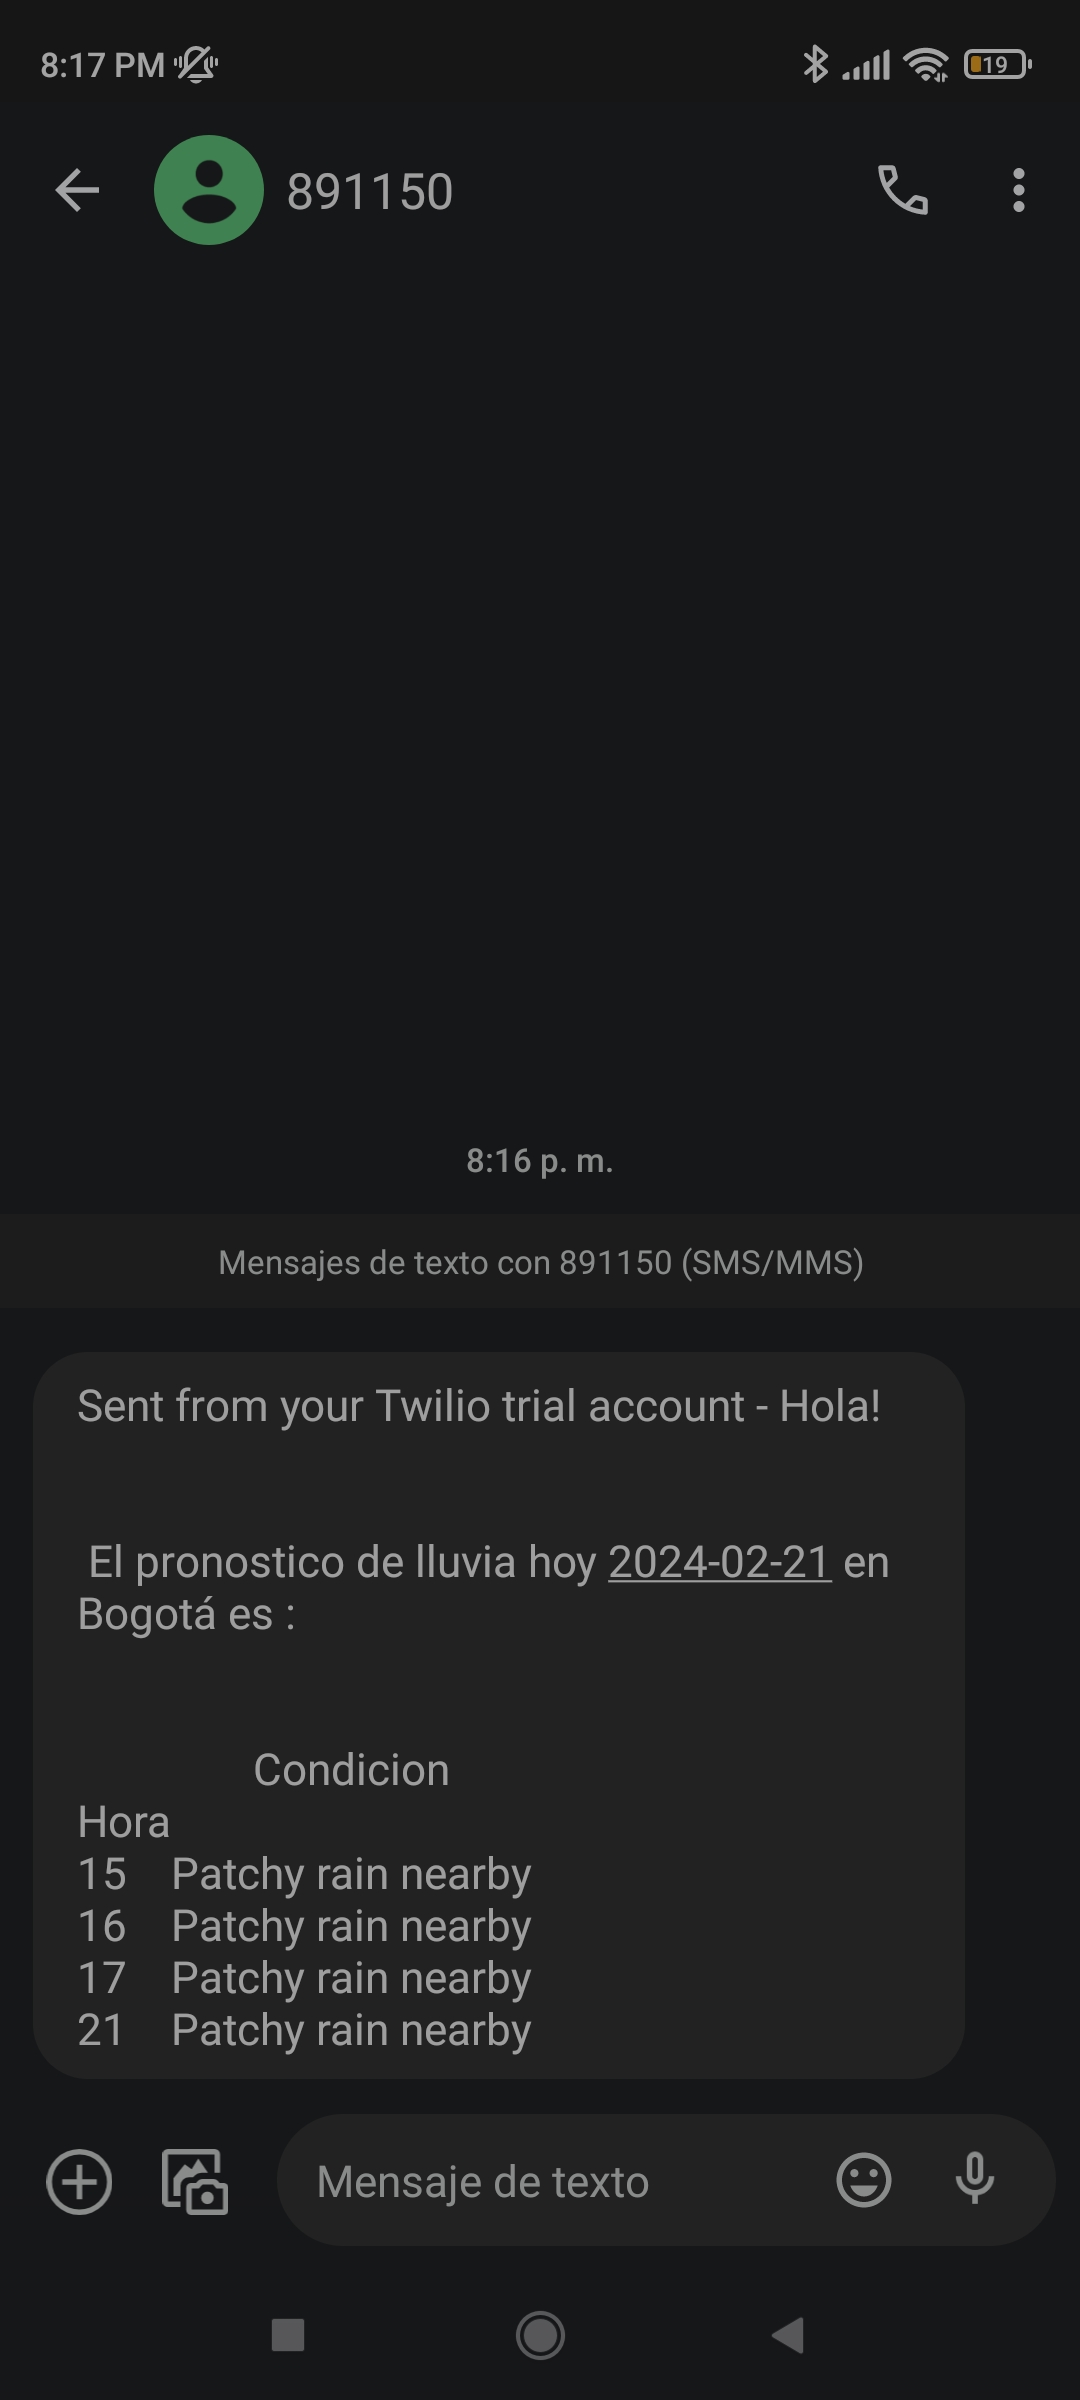